In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [78]:
# finalize model and make a prediction for monthly births with random forest
from numpy import asarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [3]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Hitachi/Data/final_data.csv"
# data_path = "final_data.csv"
data_df = pd.read_csv(data_path)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27552 entries, 0 to 27551
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      27552 non-null  int64  
 1   datetime                        27552 non-null  object 
 2   Demand (MW)                     27552 non-null  float64
 3   Temperature                     27552 non-null  float64
 4   dewpoint                        27552 non-null  float64
 5   humidity                        27552 non-null  float64
 6   precipitation                   27552 non-null  float64
 7   precipprob                      27552 non-null  float64
 8   snow                            27552 non-null  float64
 9   snowdepth                       27552 non-null  float64
 10  windgust                        27552 non-null  float64
 11  windspeed                       27552 non-null  float64
 12  sealevelpressure                

In [4]:
def min_max_normalize_dataframe(df, columns):
    df_normalized = df.copy()
    for column in columns:
        if df[column].dtype in [int, float]:
            min_val = df[column].min()
            max_val = df[column].max()
            df_normalized[column] = (df[column] - min_val) / (max_val - min_val)
    return df_normalized

data_df.drop(columns=["Unnamed: 0", "datetime"], inplace=True)
features_columns = list(data_df.columns)
features_columns.remove('Demand (MW)')# removing the Demand (MW)

normalized_df = min_max_normalize_dataframe(data_df, columns = features_columns)
transformed_df = normalized_df[features_columns].apply(np.log1p)

transformed_df["Demand (MW)"] = data_df["Demand (MW)"]
transformed_df.head()

,Temperature,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,windgust,windspeed,sealevelpressure,...,rain,snow.1,Clear,Freezing Drizzle/Freezing Rain,Ice,Overcast,Partially cloudy,Rain,Snow,Demand (MW)
0,0.349596,0.383234,0.491779,0.0,0.0,0.0,0.0,0.23543,0.116613,0.387838,...,0.0,0.0,0.000000,0.0,0.0,0.693147,0.000000,0.0,0.0,445.8
1,0.349596,0.389739,0.510850,0.0,0.0,0.0,0.0,0.23543,0.116613,0.386469,...,0.0,0.0,0.000000,0.0,0.0,0.693147,0.000000,0.0,0.0,424.5
2,0.349596,0.396202,0.530131,0.0,0.0,0.0,0.0,0.23543,0.085695,0.387838,...,0.0,0.0,0.000000,0.0,0.0,0.693147,0.000000,0.0,0.0,423.5
3,0.343529,0.389739,0.529492,0.0,0.0,0.0,0.0,0.23543,0.116613,0.386469,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.693147,0.0,0.0,418.8
4,0.329914,0.383234,0.553636,0.0,0.0,0.0,0.0,0.23543,0.085695,0.385098,...,0.0,0.0,0.693147,0.0,0.0,0.000000,0.000000,0.0,0.0,414.8


# Training of the Random Forest Model on WHOLE DATA

In [5]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [6]:
# load the dataset
series = pd.DataFrame(transformed_df["Demand (MW)"])
values = series.values

In [7]:
values.shape

(27552, 1)

In [8]:
# Use first 20% of dataset as the test dataset
# Use 80 % of data as train dataset
# 20% of total data (27552) = 5510
train_values = values[5510:, :]
test_values = values[:5510, :]
train_values.shape, test_values.shape

((22042, 1), (5510, 1))

In [9]:
# 3 weeks of data is used as prior data => 24 * 7 * 3 = 504
number_of_weeks = 3
previous_data_dependency_hours = 24*7*number_of_weeks
# transform the time series data into supervised learning
train_supervised_data = series_to_supervised(train_values, n_in=previous_data_dependency_hours)
test_supervised_data = series_to_supervised(test_values, n_in=previous_data_dependency_hours)

In [10]:
train_supervised_data.shape

(21538, 505)

In [11]:
# split into input and output columns
train_X, train_y = train_supervised_data[:, :-1], train_supervised_data[:, -1]
train_X.shape, train_y.shape

((21538, 504), (21538,))

In [ ]:
# fit model
n_estimators = 1000
model = RandomForestRegressor(n_estimators=n_estimators, verbose=1, n_jobs=-1)
model.fit(train_X, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.1min finished


RandomForestRegressor(n_estimators=1000, n_jobs=-1, verbose=1)

In [13]:
# model_path = "MODEL ARCHIVE/univariate_rfr.pkl"
model_path = "/content/drive/MyDrive/Colab Notebooks/Hitachi/MODEL ARCHIVE/univariate_rfr.pkl"

In [ ]:
save_model = False
if save_model:
  joblib.dump(model, model_path)

## Testing the model

In [14]:
loaded_model = joblib.load(model_path)

In [15]:
test_X, test_y = test_supervised_data[:, :-1], test_supervised_data[:, -1]

In [16]:
test_prediction = loaded_model.predict(test_X)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    2.5s finished


In [17]:
test_y.shape, test_prediction.shape

((5006,), (5006,))

The Mean Squared Error (MSE) is a common metric used to measure the average squared difference between the predicted values and the actual values in a regression problem.

MAPE expresses the prediction error as a percentage of the actual value. It is useful when you want to understand the relative error.

MAE measures the average absolute difference between the actual and predicted
values. It is in the same unit as the original data.

In [79]:
# Mean squared Error and Mean Absolute Percentage Error (MAPE)
print(mean_squared_error(test_y, test_prediction))
print(mean_absolute_percentage_error(test_y, test_prediction))
print(mean_absolute_error(test_y, test_prediction))

133.10538747378322
0.01651178390464943
8.726201438274073


In [19]:
def plot_truth_vs_pred(test_y, test_prediction, number_to_plot):
    pred_df = pd.DataFrame({'ground_truth' : test_y[:number_to_plot], 'prediction' : test_prediction[:number_to_plot]})
    sns.lineplot(data=pred_df)
    plt.title(f"Ground Truth vs Predicted Demand {number_to_plot} datapoints")

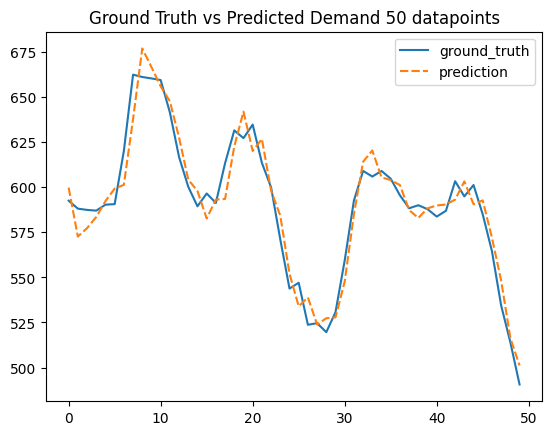

In [20]:
plot_truth_vs_pred(test_y, test_prediction, number_to_plot=50)

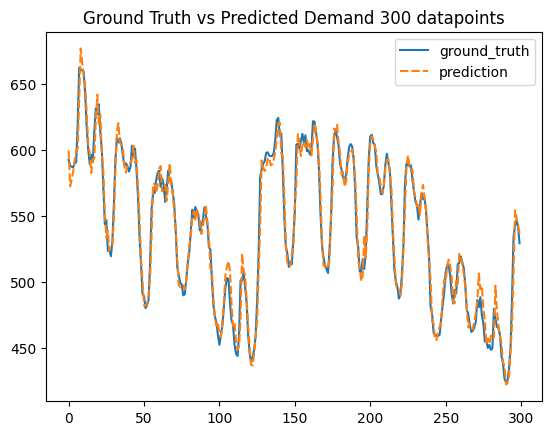

In [21]:
plot_truth_vs_pred(test_y, test_prediction, number_to_plot=300)

## Submission Prediction

In [35]:
def week_demand_prediction(last_3_week_data):
  week_demand = []
  count = 0
  last_3_week_data = last_3_week_data.reshape((1, 504))
  while count < 24*7:
    pred = loaded_model.predict(last_3_week_data)
    last_3_week_data = np.concatenate((last_3_week_data[:, 1:], pred.reshape(1, -1)), axis=1)
    count += 1
    week_demand.append(float(pred))

  return week_demand

In [36]:
last_3_week_data = values[-previous_data_dependency_hours:]
week_demand = week_demand_prediction(last_3_week_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Paral

In [39]:
len(week_demand), week_demand[:2]

(168, [440.82909999999964, 432.14809999999915])

In [42]:
# plot the week demand prediction
last_3_week_data = values[-previous_data_dependency_hours:]
last_3_week_data = last_3_week_data.reshape((1, 504))
week_demand_series = np.array(week_demand)
last_3_week_data.shape, week_demand_series.shape

((1, 504), (168,))

In [47]:
past_values = list(last_3_week_data.ravel())
forecast_values = list(week_demand_series)

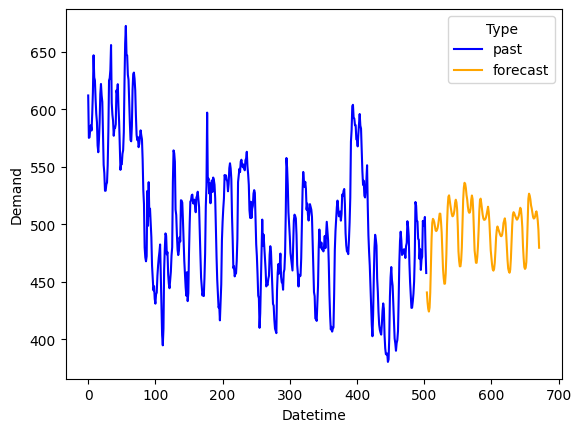

In [61]:
# Create a list of colors for past and forecast values
colors = ['blue'] * len(past_values) + ['orange'] * len(forecast_values)
types = ['past'] * len(past_values) + ['forecast'] * len(forecast_values)

# Combine past and forecast values into a single array
combined_values = past_values + forecast_values

# Create a DataFrame for seaborn
import pandas as pd
df = pd.DataFrame({'Values': combined_values, 'Color': colors, 'Type' : types})

# Plot using seaborn
plot = sns.lineplot(data=df, x=df.index, y='Values', hue='Type', palette={'past': 'blue', 'forecast': 'orange'})
plt.ylabel("Demand")
plt.xlabel("Datetime")
# Show the plot
plt.show()

In [62]:
len(forecast_values)

168

In [70]:
forecast_path = "/content/drive/MyDrive/Colab Notebooks/Hitachi/FORECAST_DATA/univariate_forecast_data.pkl"
joblib.dump(forecast_values, forecast_path)

['/content/drive/MyDrive/Colab Notebooks/Hitachi/FORECAST_DATA/univariate_forecast_data.pkl']

In [71]:
loaded_forecast = joblib.load(forecast_path)

In [72]:
loaded_forecast == week_demand

True

In [80]:
# for validation
last_3_week_data = values[-previous_data_dependency_hours:]
last_3_week_data = last_3_week_data.reshape((1, 504))
past_values = list(last_3_week_data.ravel())
past_values

[611.9,
 575.1,
 575.5,
 582.4,
 586.0,
 581.5,
 595.8,
 614.7,
 646.8,
 627.5,
 625.0,
 608.7,
 595.9,
 588.7,
 568.5,
 562.6,
 573.5,
 588.5,
 613.0,
 621.9,
 612.0,
 606.3,
 580.3,
 551.6,
 544.5,
 529.1,
 529.2,
 534.6,
 536.3,
 551.1,
 580.5,
 625.0,
 626.9,
 634.0,
 655.7,
 605.4,
 595.4,
 590.0,
 576.9,
 583.5,
 583.7,
 586.9,
 616.3,
 613.3,
 621.7,
 602.3,
 589.3,
 567.5,
 547.3,
 552.3,
 552.1,
 561.2,
 564.4,
 580.1,
 623.1,
 657.1,
 672.3,
 647.4,
 646.7,
 630.0,
 625.6,
 605.7,
 588.0,
 573.2,
 572.1,
 585.3,
 616.5,
 630.4,
 631.8,
 626.4,
 616.4,
 594.5,
 577.8,
 573.1,
 575.7,
 567.0,
 569.8,
 575.9,
 581.6,
 577.3,
 573.9,
 556.4,
 529.8,
 517.6,
 480.0,
 471.2,
 467.9,
 472.3,
 529.0,
 498.7,
 536.6,
 507.6,
 513.6,
 501.3,
 488.7,
 464.3,
 453.5,
 442.7,
 446.2,
 435.2,
 431.1,
 439.3,
 440.7,
 455.2,
 464.2,
 470.9,
 476.0,
 482.5,
 455.9,
 430.1,
 403.8,
 394.9,
 409.4,
 460.6,
 478.6,
 492.1,
 490.1,
 473.9,
 475.8,
 456.5,
 448.4,
 444.5,
 452.2,
 458.8,
 472.8,


# Submission Data Fill Up
* OUTER JOIN the demand and weather data on datetime
* fill up the null values of demand with predicted values

In [81]:
project_path = "/content/drive/MyDrive/Colab Notebooks/Hitachi/"
demand_forecast_data_1_path = "Data/Demand Forecasting/Demand Forecasting Demand Data upto Feb 21.csv"
demand_forecast_data_1 = pd.read_csv(project_path + demand_forecast_data_1_path)
demand_forecast_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27552 entries, 0 to 27551
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     27552 non-null  object 
 1   Demand (MW)  27552 non-null  float64
dtypes: float64(1), object(1)
memory usage: 430.6+ KB


In [82]:
demand_forecast_data_2_path = "Data/Demand Forecasting/Demand Forecasting Weather Data upto Feb 28.csv"
demand_forecast_data_2 = pd.read_csv(project_path + demand_forecast_data_2_path)
demand_forecast_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27720 entries, 0 to 27719
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              27720 non-null  object 
 1   datetime          27720 non-null  object 
 2   Temperature       27720 non-null  float64
 3   feelslike         27720 non-null  float64
 4   dewpoint          27720 non-null  float64
 5   humidity          27720 non-null  float64
 6   precipitation     27720 non-null  float64
 7   precipprob        27720 non-null  int64  
 8   preciptype        2751 non-null   object 
 9   snow              27702 non-null  float64
 10  snowdepth         27702 non-null  float64
 11  windgust          12223 non-null  float64
 12  windspeed         27720 non-null  float64
 13  winddirection     27720 non-null  float64
 14  sealevelpressure  27702 non-null  float64
 15  cloudcover        27720 non-null  float64
 16  visibility        27702 non-null  float6

In [110]:
demand_forecast_data_1.tail()

,datetime,Demand (MW)
27547,2/21/2023 19:00,498.7
27548,2/21/2023 20:00,498.8
27549,2/21/2023 21:00,506.4
27550,2/21/2023 22:00,478.8
27551,2/21/2023 23:00,457.7


In [114]:
to_forecast_demand_df = demand_forecast_data_2.tail(168)
to_forecast_demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 27552 to 27719
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              168 non-null    object 
 1   datetime          168 non-null    object 
 2   Temperature       168 non-null    float64
 3   feelslike         168 non-null    float64
 4   dewpoint          168 non-null    float64
 5   humidity          168 non-null    float64
 6   precipitation     168 non-null    float64
 7   precipprob        168 non-null    int64  
 8   preciptype        6 non-null      object 
 9   snow              168 non-null    float64
 10  snowdepth         168 non-null    float64
 11  windgust          168 non-null    float64
 12  windspeed         168 non-null    float64
 13  winddirection     168 non-null    float64
 14  sealevelpressure  168 non-null    float64
 15  cloudcover        168 non-null    float64
 16  visibility        168 non-null    floa

In [116]:
to_forecast_demand_df.head()

,Name,datetime,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,preciptype,snow,...,solarradiation,uvindex,severerisk,conditions,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Demand (MW)
27552,Pokhara,2/22/2023 0:00,55.1,55.1,32.0,41.25,0.0,0,NaN,0.0,...,0.0,0,10.0,Overcast,NaN,NaN,NaN,NaN,NaN,506.4000
27553,Pokhara,2/22/2023 1:00,56.9,56.9,35.1,43.72,0.0,0,NaN,0.0,...,0.0,0,10.0,Overcast,NaN,NaN,NaN,NaN,NaN,478.8000
27554,Pokhara,2/22/2023 2:00,56.9,56.9,38.0,49.13,0.0,0,NaN,0.0,...,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN,457.7000
27555,Pokhara,2/22/2023 3:00,57.8,57.8,41.0,53.38,0.0,0,NaN,0.0,...,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN,440.8291
27556,Pokhara,2/22/2023 4:00,57.8,57.8,46.1,64.98,0.0,0,NaN,0.0,...,0.0,0,10.0,Overcast,NaN,NaN,NaN,NaN,NaN,432.1481


In [120]:
forecast_datetime = to_forecast_demand_df["datetime"]
week_demand_series = pd.Series(week_demand)

In [129]:
forecast_datetime.info()

<class 'pandas.core.series.Series'>
RangeIndex: 168 entries, 27552 to 27719
Series name: datetime
Non-Null Count  Dtype 
--------------  ----- 
168 non-null    object
dtypes: object(1)
memory usage: 1.4+ KB


In [132]:
forecast_datetime_list = list(forecast_datetime)
forecast_datetime_list[:5]

['2/22/2023 0:00',
 '2/22/2023 1:00',
 '2/22/2023 2:00',
 '2/22/2023 3:00',
 '2/22/2023 4:00']

In [123]:
len(forecast_datetime_list), len(week_demand_series)

(168, 168)

In [133]:
week_forecast_demand_df = pd.DataFrame({'datetime' : forecast_datetime_list, 'Demand (MW)' : week_demand})
week_forecast_demand_df.head()

,datetime,Demand (MW)
0,2/22/2023 0:00,440.8291
1,2/22/2023 1:00,432.1481
2,2/22/2023 2:00,426.5244
3,2/22/2023 3:00,424.2154
4,2/22/2023 4:00,427.6063


In [135]:
forecast_path = "/content/drive/MyDrive/Colab Notebooks/Hitachi/FORECAST_DATA/unicast_forecast.csv"
week_forecast_demand_df.to_csv(forecast_path, index=False)

In [136]:
loaded_week_forecast_demand_df = pd.read_csv(forecast_path)
loaded_week_forecast_demand_df.head()

,datetime,Demand (MW)
0,2/22/2023 0:00,440.8291
1,2/22/2023 1:00,432.1481
2,2/22/2023 2:00,426.5244
3,2/22/2023 3:00,424.2154
4,2/22/2023 4:00,427.6063


In [137]:
loaded_week_forecast_demand_df.tail()

,datetime,Demand (MW)
163,2/28/2023 19:00,511.2772
164,2/28/2023 20:00,508.3097
165,2/28/2023 21:00,503.1331
166,2/28/2023 22:00,494.9390
167,2/28/2023 23:00,479.6474
